In [2]:
import os
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p sandbox #let's put all stuff in the sandbox
os.chdir("sandbox")

### Download a sample of ActinoMock Nanopore data

In [5]:
if not os.path.exists('ActinoMock_Nanopore.seq.gz'):
    !wget https://s3.amazonaws.com/lizhen-notebook/share/ActinoMock_Nanopore.seq.gz

--2019-01-25 06:05:17--  https://s3.amazonaws.com/lizhen-notebook/share/ActinoMock_Nanopore.seq.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.176.229
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.176.229|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 480042209 (458M) [application/x-gzip]
Saving to: ‘ActinoMock_Nanopore.seq.gz’

ActinoMock_Nanopore 100%[===================>] 457.80M  72.6MB/s    in 6.6s    

2019-01-25 06:05:24 (69.7 MB/s) - ‘ActinoMock_Nanopore.seq.gz’ saved [480042209/480042209]



In [6]:
!cat ActinoMock_Nanopore.seq.gz | gunzip > data.seq

### encode  reads

In [10]:
!python ../../scripts/fastseq/hashSeq.py -i data.seq --hash lsh -o data.hash -k 15 --hash_size 25 --bucket 67108864 > /dev/null  2> error.log

^C


### train a model

In [12]:
#change epoch to 1 to save time
!../../fastseq skipgram -input data.hash -output model  -epoch 5 -dim 100 -lr 0.1

Read 1639M words
Number of words:  6838356
Number of labels: 0
Progress: 100.0% words/sec/thread:   50888 lr:  0.000000 loss:  0.068224 ETA:   0h 0mm  3h37mh35m  3h32m 0.593038 ETA:   3h31m  3h31mh30mm29mm ETA:   3h27m 0.093183 loss:  0.448553 ETA:   3h27mm25m  7.4% words/sec/thread:   51228 lr:  0.092600 loss:  0.417137 ETA:   3h25m  3h25m24m  3h21m21mh21mmmmmmm  3h16m15mm14m14m  3h14m ETA:   3h12mh11mh10m ETA:   3h10mm 8m loss:  0.236983 ETA:   3h 8mm 0.231763 ETA:   3h 7m ETA:   3h 4mh 3mmmh 2m 0.080791 loss:  0.202899 ETA:   2h59mmh57m  2h56m  2h55m53m52mmm 22.7% words/sec/thread:   51178 lr:  0.077261 loss:  0.180895 ETA:   2h51m51mh50m49m 24.0% words/sec/thread:   51179 lr:  0.075961 loss:  0.174668 ETA:   2h48m47m  2h47m loss:  0.171733 ETA:   2h47mm47m47m 25.1% words/sec/thread:   51171 lr:  0.074924 loss:  0.169913 ETA:   2h46mm45m ETA:   2h45m 0.166406 ETA:   2h44m44mm43m 26.4% words/sec/thread:   51167 lr:  0.073614 loss:  0.164248 ETA:   2h43m43m43m43mh42m 26.9% words/sec/t

### Now the model is trained.  To visualize it, first get vectors of reads. 

In [14]:
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec

embedding,dim_vec = read_embedding("model.vec")
seqvectors = []
lines=[]
with open("data.hash") as fin:
    for line in fin:
        if len(lines)>=20000: break  #The data is already shuffled, so just take a few from head
        lines.append(line)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)#np.zeros([dim_vec],dtype=np.float32))
    #if i>10: break    

### Next get the labels

In [24]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0, nrows=20000)
seqs.columns=['id']
seqs['organism']=seqs['id'].map(lambda u: u.split('-')[1])
seqs['class']=seqs['id'].map(lambda u: u.split('-')[2])
seqs['phylum']=seqs['id'].map(lambda u: u.split('-')[3])
seqs['vec']=seqvectors
seqs.head()

,id,organism,class,phylum,vec
0,,,,,
47914,47914-2616644829-Gammaproteobacteria-Proteobac...,2616644829,Gammaproteobacteria,Proteobacteria,"[0.1383286156387552, -0.034203138076849555, -0..."
78419,78419-2623620618-Gammaproteobacteria-Proteobac...,2623620618,Gammaproteobacteria,Proteobacteria,"[0.13908534754174898, -0.024653525567009185, -..."
67045,67045-2623620617-Gammaproteobacteria-Proteobac...,2623620617,Gammaproteobacteria,Proteobacteria,"[0.15130306295543952, -0.025146793146259394, -..."
27710,27710-2615840601-Alphaproteobacteria-Proteobac...,2615840601,Alphaproteobacteria,Proteobacteria,"[0.13301048674004837, -0.042611200268417304, -..."
31701,31701-2615840697-Gammaproteobacteria-Proteobac...,2615840697,Gammaproteobacteria,Proteobacteria,"[0.13625741456066692, -0.034393847364547134, -..."


### Now train TSNE

In [25]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape

(20000, 100)

In [26]:
%time Y = tsne.fit_transform(X)

CPU times: user 10min 43s, sys: 13.6 s, total: 10min 57s
Wall time: 1min 24s


### visualization

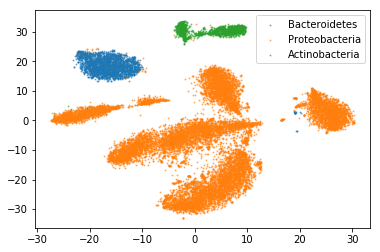

In [29]:
labels=seqs['phylum'].values
legends=list(set(labels))
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)
plt.legend(legends)

['Actinobacteria', 'Alphaproteobacteria', 'Gammaproteobacteria', 'Flavobacteriia']


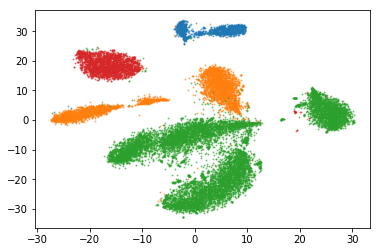

In [33]:
labels=seqs['class'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)

['2617270709', '2616644829', '2615840527', '2623620617', '2615840533', '2623620567', '2623620557', '2615840601', '2615840697', '2615840646', '2623620618']


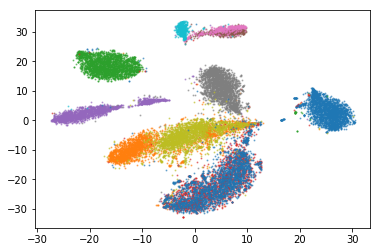

In [34]:
labels=seqs['organism'].values
legends=list(set(labels))
print (legends)
for label in legends:            
    plt.scatter(Y[labels==label][:,0],Y[labels==label][:,1],alpha=0.5,s=1)